In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/ms4610project"

/content/drive/MyDrive/ms4610project


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
# models 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss , classification_report, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initial Models 

In [ ]:
df = pd.read_csv("Training Data_2021.csv")
df = df.replace('missing', np.NaN).replace('na', np.NaN)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
test_df = pd.read_csv("Test Data_2021.csv")
test_df = test_df.replace('missing', np.NaN).replace('na', np.NaN)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
def get_float(x):
  if x is np.NaN:
    return x 
  else :
    return float(x)

df_new  = df.copy()
test_df_new = test_df.copy()
# df_new.columns
# get the float values for columns that can be float 
float_columns= ['mvar1', 'mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6','mvar7', 'mvar8', 'mvar9', 'mvar10', 'mvar11', 'mvar12', 'mvar13','mvar14', 'mvar15', 'mvar16', 'mvar17', 'mvar18', 'mvar19', 'mvar20',
'mvar21', 'mvar22', 'mvar23', 'mvar24', 'mvar25', 'mvar26', 'mvar27','mvar28', 'mvar29', 'mvar30', 'mvar31', 'mvar32', 'mvar33', 'mvar34','mvar35', 'mvar36', 'mvar37', 'mvar38', 'mvar39', 'mvar40', 'mvar41',
'mvar42', 'mvar43', 'mvar44', 'mvar45', 'mvar46'
]
for column in float_columns:
  df_new[column]= df_new[column].apply(get_float)
  test_df_new[column] = test_df_new[column].apply(get_float)

In [ ]:
columns =[ 'mvar1', 'mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6','mvar7', 'mvar8', 'mvar9', 'mvar10', 'mvar11', 'mvar12', 'mvar13','mvar14', 'mvar15', 'mvar16', 'mvar17', 'mvar18', 'mvar19', 'mvar20',
'mvar21', 'mvar22', 'mvar23', 'mvar24', 'mvar25', 'mvar26', 'mvar27','mvar28', 'mvar29', 'mvar30', 'mvar31', 'mvar32', 'mvar33', 'mvar34','mvar35', 'mvar36', 'mvar37', 'mvar38', 'mvar39', 'mvar40', 'mvar41',
'mvar42', 'mvar43', 'mvar44', 'mvar45', 'mvar46','mvar47']

feature_unique_values = []
for feature in columns:
  temp = df_new[df_new[feature] != np.NaN].copy()
  num_uniqe_values = temp[feature].unique().__len__()
  feature_unique_values.append({
      "feature":feature, "num_unique_values" : num_uniqe_values
  })
feature_unique_values_df = pd.DataFrame(feature_unique_values)
feature_unique_values_df.head(3)

,feature,num_unique_values
0,mvar1,455
1,mvar2,24657
2,mvar3,18950


In [ ]:
remove_features = ['mvar22','mvar26','mvar15','mvar35','mvar30','mvar23','mvar45','mvar11','mvar41','mvar31','mvar40'] # on the basis of % null values


feature_unique_values_df_filtered =feature_unique_values_df[feature_unique_values_df['feature'].apply(lambda x : x not in remove_features)]

In [ ]:
dist_hist_threshold =  50
categorical_features = feature_unique_values_df_filtered[feature_unique_values_df_filtered['num_unique_values']<dist_hist_threshold].sort_values(by='num_unique_values')['feature'].to_list()
quantitative_features =  feature_unique_values_df_filtered[feature_unique_values_df_filtered['num_unique_values'] > dist_hist_threshold].sort_values(by='num_unique_values')['feature'].to_list()
print(f"number of categorical feature {len(categorical_features)}  number of quatitative features {len(quantitative_features)}")

number of categorical feature 9  number of quatitative features 27


In [ ]:
# imputation with mean and median 
test_df_imputed = test_df_new.copy()
df_imputed = df_new.copy()
for feature in quantitative_features:
  df_imputed[feature].fillna(value =df_imputed[feature].mean(), inplace=True)
  test_df_imputed[feature].fillna(value =df_imputed[feature].mean(), inplace=True)


for feature in categorical_features:
  df_imputed[feature] = df_imputed[feature].fillna(value =df_imputed[feature].mode()[0])
  test_df_imputed[feature] = test_df_imputed[feature].fillna(value =df_imputed[feature].mode()[0])


In [ ]:
df_imputed['mvar47_encoded'] = df_imputed['mvar47'].apply(lambda x :1 if x=='C' else 0)
test_df_imputed['mvar47_encoded'] = test_df_imputed['mvar47'].apply(lambda x :1 if x=='C' else 0)

In [ ]:
input_features = [ 'mvar1', 'mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6',
       'mvar7', 'mvar8', 'mvar9', 'mvar10', 'mvar11', 'mvar12', 'mvar13',
       'mvar14', 'mvar15', 'mvar16', 'mvar17', 'mvar18', 'mvar19', 'mvar20',
       'mvar21', 'mvar22', 'mvar23', 'mvar24', 'mvar25', 'mvar26', 'mvar27',
       'mvar28', 'mvar29', 'mvar30', 'mvar31', 'mvar32', 'mvar33', 'mvar34',
       'mvar35', 'mvar36', 'mvar37', 'mvar38', 'mvar39', 'mvar40', 'mvar41',
       'mvar42', 'mvar43', 'mvar44', 'mvar45', 'mvar46' , 'mvar47_encoded'
       ]

target_features = ['default_ind']

In [ ]:
from sklearn.model_selection import train_test_split
x , y = df_imputed[input_features].drop(columns=remove_features), df_imputed[target_features]
x_train, x_val, y_train, y_val         = train_test_split(x,y.values.ravel(),test_size=0.25)

In [ ]:
def evaluate_model(model):
  model.fit(x_train, y_train)
  y_pred_train = model.predict(x_train)
  y_pred_val = model.predict(x_val)
  print(classification_report(y_val, y_pred_val))

  y_pred_train = model.predict_proba(x_train)
  y_pred_val = model.predict_proba(x_val)
  print(f"training log loss {log_loss(y_train,y_pred_train)} test log loss {log_loss(y_val, y_pred_val)}")
  print(f" roc auc score :{roc_auc_score(y_val, y_pred_val[:,1])}")
  return model 

In [ ]:
classifiers = {
    "LogisticRegression":LogisticRegression(max_iter=300),
    "KNeighborsClassifier":KNeighborsClassifier(3),
   # "SVC":SVC(kernel="rbf", C=0.025, probability=True), # it was very time consuming
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "AdaBoostClassifier":AdaBoostClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "GaussianNB":GaussianNB()
    }

In [ ]:
for key in classifiers:
  print(f"================{key}=====================\n")
  evaluate_model(classifiers[key])


================LogisticRegression=====================

              precision    recall  f1-score   support

           0       0.71      1.00      0.83     14781
           1       0.49      0.01      0.01      5969

    accuracy                           0.71     20750
   macro avg       0.60      0.50      0.42     20750
weighted avg       0.65      0.71      0.60     20750

training log loss 0.5529859082188305 test log loss 0.5501304460589328
 roc auc score :0.7059138419529022
================KNeighborsClassifier=====================

              precision    recall  f1-score   support

           0       0.76      0.81      0.79     14781
           1       0.44      0.36      0.39      5969

    accuracy                           0.68     20750
   macro avg       0.60      0.59      0.59     20750
weighted avg       0.67      0.68      0.67     20750

training log loss 0.33410708072805106 test log loss 3.9785627663009087
 roc auc score :0.6284442592118
================Decisi

In [ ]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier()
evaluate_model(xgb_classifier)

              precision    recall  f1-score   support

           0       0.79      0.92      0.85     14781
           1       0.67      0.41      0.51      5969

    accuracy                           0.77     20750
   macro avg       0.73      0.66      0.68     20750
weighted avg       0.76      0.77      0.75     20750

training log loss 0.4810985545529479 test log loss 0.4878716853903719
 roc auc score :0.7827223347963531


XGBClassifier()

### The  tree based models are capturing the underlaying relationship to good extent so we are fine turing them 
 


*    XGBoost ('eXtreme Gradient Boosting') and sklearn's GradientBoost are fundamentally the same as they are both gradient boosting implementations.
But xgboost is faster and have better regularisation 



# Fine Tuning 

In [ ]:
counter = Counter(y)
scale_pos_weight = counter[0] / counter[1]

In [ ]:
for n_estimators in [30,50,70,100,200]:
  xgb = XGBClassifier(n_estimators=n_estimators,max_depth=5, scale_pos_weight=scale_pos_weight )
  print(f"================{n_estimators}=====================\n")
  evaluate_model(xgb)

================30=====================

Mean ROC AUC: 0.78260
================50=====================

Mean ROC AUC: 0.78449
================70=====================

Mean ROC AUC: 0.78532
================100=====================

Mean ROC AUC: 0.78555
================200=====================

Mean ROC AUC: 0.78496


In [5]:
df = pd.read_csv("Training Data_2021.csv")
df = pd.get_dummies(df, columns=['mvar47'],drop_first = True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
y = df['default_ind']
counter = Counter(y)
estimate = counter[0] / counter[1]

In [7]:
removed = ['application_key','default_ind']
df = df.drop(removed, axis = 1)

In [8]:
X = df.apply(pd.to_numeric, errors='coerce')

In [9]:
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Mean ROC AUC: %.5f' % mean(scores))

In [10]:
model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100,scale_pos_weight=estimate,objective= 'binary:logistic')
evaluate_model(model)

Mean ROC AUC: 0.78441


In [11]:
model = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=30,scale_pos_weight=estimate,objective= 'binary:logistic')
evaluate_model(model)


Mean ROC AUC: 0.77719


In [12]:
model = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=30,scale_pos_weight=estimate,objective= 'binary:logistic')
evaluate_model(model)

Mean ROC AUC: 0.78260


In [13]:
model = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=70,scale_pos_weight=estimate,objective= 'binary:logistic')
evaluate_model(model)

Mean ROC AUC: 0.78532


In [ ]:
!pip install shap 
import shap

     |████████████████████████████████| 564 kB 30.5 MB/s 


In [ ]:
import lightgbm as lgb


In [ ]:
m = lgb.LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(m, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.78555


In [ ]:
m.fit(X,y)

LGBMClassifier()

In [ ]:
df1 = pd.read_csv("Test Data_2021.csv")
df1 = pd.get_dummies(df1, columns=['mvar47'],drop_first = True)
X1 = df1.copy()
X1 = X1.drop('application_key', axis = 1)
X1 = X1.apply(pd.to_numeric, errors='coerce')

y1_pred = np.around(m.predict(X1))
submission = df1[['application_key']].copy()
submission['default_key'] = y1_pred
submission.to_csv("Group_29_12.csv")


Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


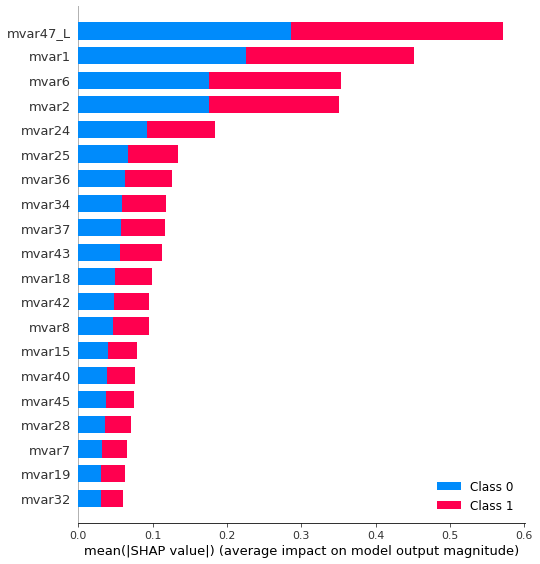

In [ ]:
explainer = shap.TreeExplainer(m)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

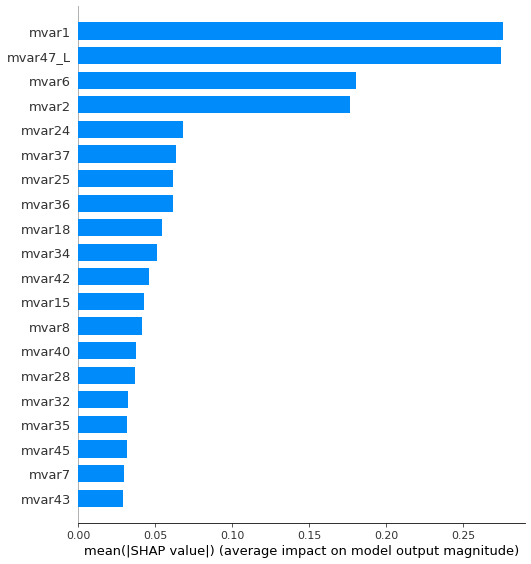

In [ ]:
model = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=70,scale_pos_weight=estimate,objective= 'binary:logistic')
model.fit(X_train,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")